In [ ]:
import pandas as pd 
import numpy as np
from functools import partial
from glob import glob

from pymongo import MongoClient

import statsmodels.api as sm
import scipy

from utils.misc import read_mongo, batch
from utils.geolocation import CachedGeolocator, region_fixer, locality_fixer, countryName_fixer, address_to_location
from utils.dk021 import DK021
from utils.etl import transform_dataset

%matplotlib inline

# Prepare data

## Transform Chunked

In [ ]:
batch_size = 50_000

# connect to tenders db
cursor = MongoClient()['prozorro']['etenders'].find(no_cursor_timeout=True)

try:
    for idx, b in enumerate(batch(cursor, batch_size)):

        transform_dataset(
            df=pd.DataFrame(b).rename(columns={'_id':'id'})
        ).to_parquet(f'./data/prepared/chunk_{idx}.parquet.gzip', compression='gzip') 

        print(f'chunk {idx}')
# except Exception as e:
#     print(e)
finally:
    cursor.close()

## Restore & enrich

In [ ]:
files = sorted(glob('./data/prepared/chunk_*.parquet.gzip'))

full_df = pd.read_parquet(files[0])
for f in files[1:]:
    full_df = pd.concat([full_df, pd.read_parquet(f)])


In [ ]:
classifier = DK021.load('./data/dk021.csv')

In [ ]:
classifier.get_level_category('33141113-4', level=5).description

'Бинти'

In [ ]:
# geo and classifier
fixers = {
    'locality': locality_fixer,
    'region': region_fixer,
    'countryName': countryName_fixer
}
geolocator = CachedGeolocator(cache_dir='./data/geo_cache', bad_cache_dir='./data/geo_cache_bad', verbose=False)
get_location = partial(address_to_location, geolocator=geolocator, fixers=fixers)
classifier = DK021.load('./data/dk021.csv')

full_df = (
    full_df
    .query('~items_code.isna()')
    .assign(
        items_classification_l1 = lambda d: d.items_code.apply(lambda code: classifier.get_level_category(code=code, level=1).code),
        items_classification_l2 = lambda d: d.items_code.apply(lambda code: classifier.get_level_category(code=code, level=2).code),
        items_classification_l3 = lambda d: d.items_code.apply(lambda code: classifier.get_level_category(code=code, level=3).code)
    )
    .assign(
        procuringEntity_geo = lambda d: d.procuringEntity_address.apply(lambda address:get_location(address)),
        bids_tenderers_geo = lambda d: d.tenderers_address.apply(lambda address:get_location(address)),
    )
)

geolocator.close()

# Read data

In [ ]:
from utils.misc import mem_usg

classifier = DK021.load('./data/dk021.csv')
full_df = pd.read_parquet('../full.parquet.gzip')

mem_usg(full_df)/(1024*1024)

5108.999673843384

In [ ]:
full_df.head()

,id,date,dateModified,tenderID,owner,procurementMethod,submissionMethod,numberOfBids,status,procurementMethodType,...,awards_value_amount,awards_value_currency,awards_value_valueAddedTaxIncluded,items_code,items_classification_l1,items_classification_l2,items_classification_l3,procuringEntity_geo,bids_tenderers_geo,geo_distance
0,54c44b64ee504474afaf1183c410b36c,2018-12-31 22:03:03.722108+00:00,2018-12-31 22:03:03.722108+00:00,UA-2018-11-15-000962-c,it.ua,open,electronicAuction,2,unsuccessful,aboveThresholdUA,...,279770.40,UAH,False,72610000-9,72000000-5,72600000-6,72610000-9,"[47.4970865, 34.6487214]","[49.9923181, 36.2310146]",300.877064
1,54c44b64ee504474afaf1183c410b36c,2018-12-31 22:03:03.722108+00:00,2018-12-31 22:03:03.722108+00:00,UA-2018-11-15-000962-c,it.ua,open,electronicAuction,2,unsuccessful,aboveThresholdUA,...,280612.08,UAH,False,72610000-9,72000000-5,72600000-6,72610000-9,"[47.4970865, 34.6487214]","[49.5897423, 34.5507948]",232.817393
2,4edb5e732a6743d29382e62995cf9ad7,2018-12-31 22:03:01.553692+00:00,2018-12-31 22:03:01.553692+00:00,UA-2018-11-30-001936-c,prom.ua,open,electronicAuction,3,unsuccessful,aboveThresholdUA,...,735000.00,UAH,True,15510000-6,15000000-8,15500000-3,15510000-6,"[49.7132963, 37.6141992]","[49.7132963, 37.6141992]",0.000000
3,4edb5e732a6743d29382e62995cf9ad7,2018-12-31 22:03:01.553692+00:00,2018-12-31 22:03:01.553692+00:00,UA-2018-11-30-001936-c,prom.ua,open,electronicAuction,3,unsuccessful,aboveThresholdUA,...,734650.00,UAH,True,15510000-6,15000000-8,15500000-3,15510000-6,"[49.7132963, 37.6141992]",None,NaN
4,4edb5e732a6743d29382e62995cf9ad7,2018-12-31 22:03:01.553692+00:00,2018-12-31 22:03:01.553692+00:00,UA-2018-11-30-001936-c,prom.ua,open,electronicAuction,3,unsuccessful,aboveThresholdUA,...,867200.00,UAH,True,15510000-6,15000000-8,15500000-3,15510000-6,"[49.7132963, 37.6141992]","[49.9923181, 36.2310146]",104.197987


## Explore

In [ ]:
full_df.geo_distance.isna().value_counts()

False    2154765
True      218044
Name: geo_distance, dtype: int64

In [ ]:
full_df.awards_status.value_counts()

active          894256
unsuccessful    318514
cancelled        61464
pending          29395
Name: awards_status, dtype: int64

In [ ]:
full_df[full_df.id=='98d54c150056474fbedb5420f8aad0d9'][["id", "lots_id", "bids_value_amount", "value_amount", "awards_value_amount", "procurementMethodType", "awards_status"]]

,id,lots_id,bids_value_amount,value_amount,awards_value_amount,procurementMethodType,awards_status
76067,98d54c150056474fbedb5420f8aad0d9,76da00fa661a4e51bf34f0e791833bd2,1052085.85,1060036.0,NaN,aboveThresholdUA,NaN
76068,98d54c150056474fbedb5420f8aad0d9,76da00fa661a4e51bf34f0e791833bd2,1019377.02,1060036.0,1019377.02,aboveThresholdUA,active
76069,98d54c150056474fbedb5420f8aad0d9,e32dc54313cf4e22862196b85299d87f,2267523.67,2270252.0,NaN,aboveThresholdUA,NaN
76070,98d54c150056474fbedb5420f8aad0d9,e32dc54313cf4e22862196b85299d87f,2266848.50,2270252.0,2266848.50,aboveThresholdUA,active


In [ ]:
full_df.columns

Index(['id', 'date', 'dateModified', 'tenderID', 'owner', 'procurementMethod',
       'submissionMethod', 'numberOfBids', 'status', 'procurementMethodType',
       'mainProcurementCategory', 'procuringEntity_name',
       'procuringEntity_kind', 'procuringEntity_address', 'num_lots',
       'procuringEntity_identifier_id', 'procuringEntity_identifier_scheme',
       'procuringEntity_contactPoint_email',
       'procuringEntity_contactPoint_name',
       'procuringEntity_contactPoint_telephone', 'lots_id', 'value_amount',
       'value_currency', 'value_valueAddedTaxIncluded', 'lots_status',
       'bids_date', 'bids_id', 'bids_status', 'bids_tenderers_name',
       'bids_tenderers_identifier_id', 'bids_tenderers_identifier_scheme',
       'bids_tenderers_contactPoint_email', 'bids_tenderers_contactPoint_name',
       'bids_tenderers_contactPoint_telephone', 'tenderers_address',
       'bids_value_amount', 'bids_value_currency',
       'bids_value_valueAddedTaxIncluded', 'awards_date', 

In [ ]:
full_df[full_df.id=='98d54c150056474fbedb5420f8aad0d9']

,id,date,dateModified,tenderID,owner,procurementMethod,submissionMethod,numberOfBids,status,procurementMethodType,...,awards_value_amount,awards_value_currency,awards_value_valueAddedTaxIncluded,items_code,items_classification_l1,items_classification_l2,items_classification_l3,procuringEntity_geo,bids_tenderers_geo,geo_distance
76067,98d54c150056474fbedb5420f8aad0d9,2021-09-01 07:01:34.905329+00:00,2021-09-01 07:01:34.905329+00:00,UA-2021-07-28-004065-b,e-tender.biz,open,electronicAuction,2,complete,aboveThresholdUA,...,NaN,NaN,True,33141113-4,33000000-0,33100000-1,33140000-3,"[50.587515499999995, 30.48936284691901]","[48.5167748, 34.6068797]",376.483135
76068,98d54c150056474fbedb5420f8aad0d9,2021-09-01 07:01:34.905329+00:00,2021-09-01 07:01:34.905329+00:00,UA-2021-07-28-004065-b,e-tender.biz,open,electronicAuction,2,complete,aboveThresholdUA,...,1019377.02,UAH,True,33141113-4,33000000-0,33100000-1,33140000-3,"[50.587515499999995, 30.48936284691901]","[50.587515499999995, 30.48936284691901]",0.000000
76069,98d54c150056474fbedb5420f8aad0d9,2021-09-01 07:01:34.905329+00:00,2021-09-01 07:01:34.905329+00:00,UA-2021-07-28-004065-b,e-tender.biz,open,electronicAuction,2,complete,aboveThresholdUA,...,NaN,NaN,True,33140000-3,33000000-0,33100000-1,33140000-3,"[50.587515499999995, 30.48936284691901]","[48.5167748, 34.6068797]",376.483135
76070,98d54c150056474fbedb5420f8aad0d9,2021-09-01 07:01:34.905329+00:00,2021-09-01 07:01:34.905329+00:00,UA-2021-07-28-004065-b,e-tender.biz,open,electronicAuction,2,complete,aboveThresholdUA,...,2266848.50,UAH,True,33140000-3,33000000-0,33100000-1,33140000-3,"[50.587515499999995, 30.48936284691901]","[50.587515499999995, 30.48936284691901]",0.000000


# Hypotheses

## Hypothesis #1

#### Number of bids is significant for economy

In [ ]:
data_h1 = (
    full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')]
    [['id', 'lots_id', 'numberOfBids','value_amount', 'awards_value_amount']]
    .query('numberOfBids>0')
    .groupby(by=['id', 'lots_id'])
    .agg(min)
    .reset_index()
    .groupby(by=['id'])
    .agg({
        'numberOfBids': min,
        'value_amount': sum,
        'awards_value_amount': sum,
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount) / d.value_amount,
    )
)

In [ ]:
num_of_bids_count = (
    data_h1[["id", "numberOfBids"]]
    .groupby(by=["numberOfBids"])
    .agg({
        "id": "count",
    })
    .reset_index()
    .rename(columns={"id": "count"})
    .query("count>1000")
)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='numberOfBids', ylabel='economy'>

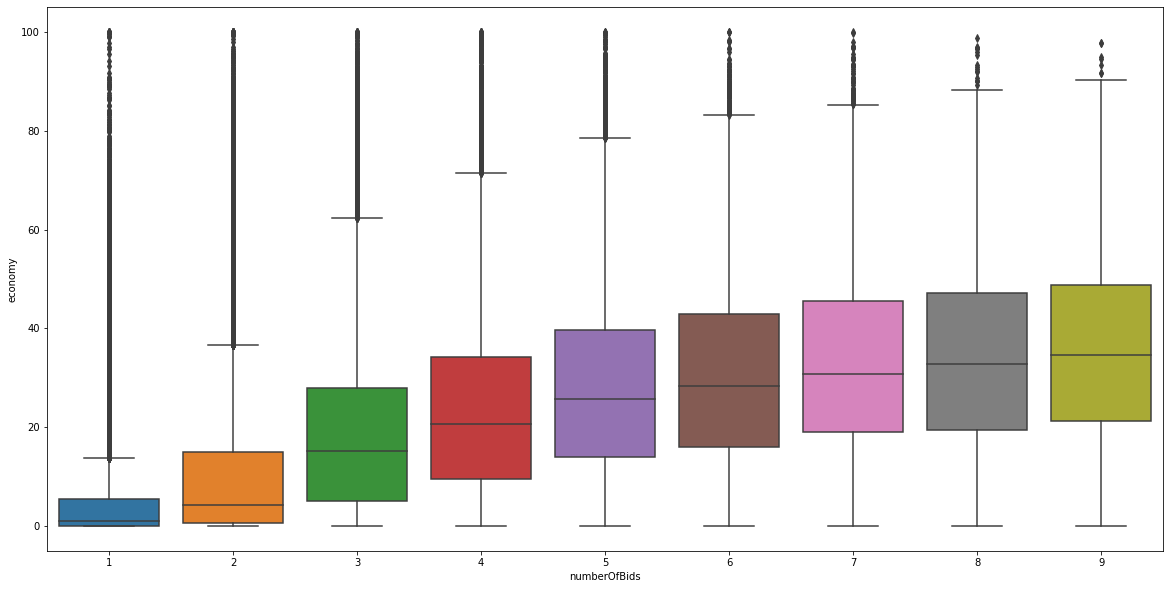

In [ ]:
data_h1_boxplot = data_h1[data_h1["numberOfBids"] < num_of_bids_count["numberOfBids"].max()]

plt.figure(figsize=(20, 10))
sns.boxplot(data=data_h1_boxplot, x="numberOfBids", y="economy")

In [ ]:
for thr in num_of_bids_count["numberOfBids"]:
    above_thr_mask = data_h1["numberOfBids"] > thr
    economy_below_thr = data_h1[~above_thr_mask]["economy"]
    economy_above_thr = data_h1[above_thr_mask]["economy"]
    
    print(f"NumberOfBids>{thr}")
    
    # t-test for equal mean values
    _, pvalue, _ = sm.stats.ttest_ind(economy_above_thr, economy_below_thr, alternative="larger")
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} mean economy than NumberOfBids<={thr}")#" with p-value={pvalue}")
    
    # print(economy_above_thr.var(), economy_below_thr.var())
    # f = economy_above_thr.var() / economy_below_thr.var()
    # pvalue = 1 - scipy.stats.f.cdf(f, len(economy_above_thr) - 1, len(economy_below_thr) - 1)
    
    # levene’s for equal variances
    _, pvalue = scipy.stats.levene(economy_below_thr, economy_above_thr)
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} economy variance than NumberOfBids<={thr}")#" with p-value={pvalue}")

NumberOfBids>1
	has sufficiently higher mean economy than NumberOfBids<=1
	has sufficiently higher economy variance than NumberOfBids<=1
NumberOfBids>2
	has sufficiently higher mean economy than NumberOfBids<=2
	has sufficiently higher economy variance than NumberOfBids<=2
NumberOfBids>3
	has sufficiently higher mean economy than NumberOfBids<=3
	has sufficiently higher economy variance than NumberOfBids<=3
NumberOfBids>4
	has sufficiently higher mean economy than NumberOfBids<=4
	has sufficiently higher economy variance than NumberOfBids<=4
NumberOfBids>5
	has sufficiently higher mean economy than NumberOfBids<=5
	has sufficiently higher economy variance than NumberOfBids<=5
NumberOfBids>6
	has sufficiently higher mean economy than NumberOfBids<=6
	has sufficiently higher economy variance than NumberOfBids<=6
NumberOfBids>7
	has sufficiently higher mean economy than NumberOfBids<=7
	has sufficiently higher economy variance than NumberOfBids<=7
NumberOfBids>8
	has sufficiently higher m

## Hypothesis #2

#### Region is significant for economy

In [ ]:
region_map_dict = {
    "Киевская": "Київська область",
    "Киевская область": "Київська область",
    "КИЕВСКАЯ ОБЛ.": "Київська область",
    "Київ": "Київська область",
    "Киев": "Київська область",
    "місто Київ": "Київська область",
    "м. Київ": "Київська область",
    "м.Київ": "Київська область",
    "Полтавская область": "Полтавська область",
    "Днепропетровская область": "Дніпропетровська область",
    "Днепропетровская обл.": "Дніпропетровська область",
    "Запорожская область": "Запорізька область",
    "Харьковская область": "Харківська область",
    "Днiпропетровська область": "Дніпропетровська область",
    "дніпропетровська": "Дніпропетровська область",
    "Одесская область": "Одеська область",
}

def format_regions(region: str):
    if not region or region in {"1", "Україна"}:
        return None
    region = region.strip()
    region = region.replace("обл.", "область")
    region = region_map_dict.get(region, region)
    words = region.split(" ")
    if len(words) == 1:
        words.append("область")
    return " ".join(words)

data_h2_orig = (
    full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')]
    [['id', 'lots_id', 'numberOfBids','value_amount', 'awards_value_amount', 'tenderers_address']]
    .query('numberOfBids>0')
    .reset_index()
)

data_h2 = (
    data_h2_orig
    .groupby(by=['id', 'lots_id'])
    .agg(min)
    .reset_index()
    .groupby(by=['id'])
    .agg({
        'numberOfBids': min,
        'value_amount': sum,
        'awards_value_amount': sum,
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount) / d.value_amount,
    )
)

regions = (
    data_h2_orig["tenderers_address"]
    .map(lambda x: x["region"])
    .map(format_regions)
)

region_counts = (
    regions
    .to_frame()
    .groupby("tenderers_address")
    .tenderers_address
    .transform("size")
)

data_h2["bids_region"] = regions
data_h2 = data_h2[regions.astype(bool) & (region_counts > 100)]

/home/roman/miniconda3/envs/study/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<AxesSubplot:xlabel='economy', ylabel='bids_region'>

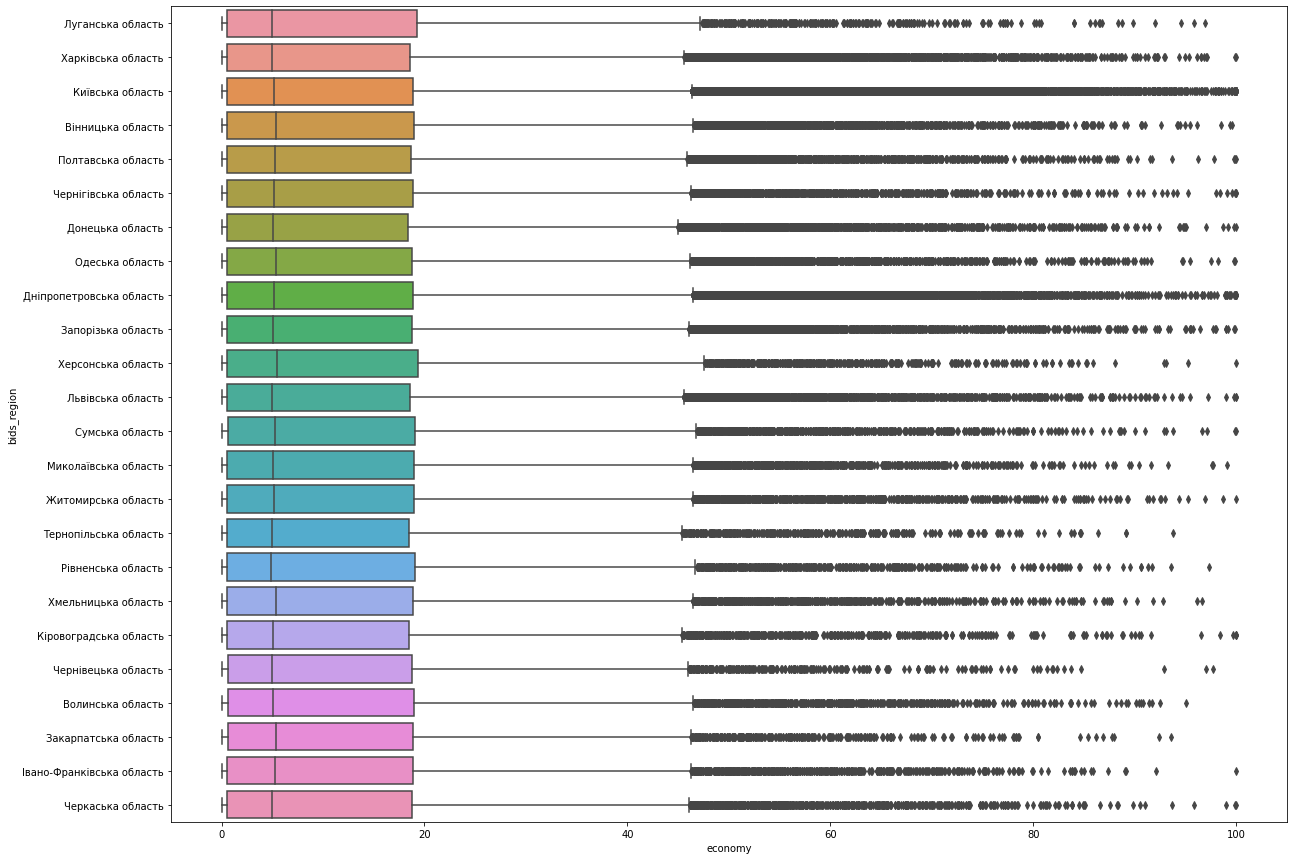

In [ ]:
plt.figure(figsize=(20, 15))
sns.boxplot(data=data_h2, x="economy", y="bids_region")

## Hypothesis #3

In [ ]:
date_grouper = pd.Grouper(key="date", freq="1M")
data_h3 = (
    full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')]
    [['id', 'lots_id', 'numberOfBids', 'date']]
    .query('numberOfBids>0')
    .groupby([, "numberOfBids"])
    .agg({
        'id': "count",
    })
    .rename(columns={"id": "count"})
    .reset_index()
)

<AxesSubplot:xlabel='date', ylabel='count'>

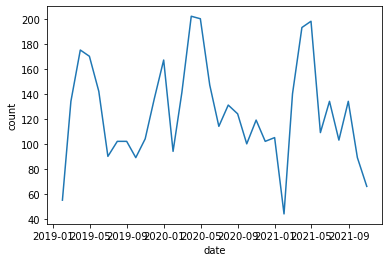

In [ ]:
sns.lineplot(data=data_h3[data_h3["numberOfBids"] == 9], x="date", y="count")

## Hypothesis #4

#### Distance is significant for economy

In [ ]:
data_h4 = full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')].query('(numberOfBids>0) & (~geo_distance.isna()) & (geo_distance > 0)')
data_h4 = (data_h4
    [['id', 'lots_id','value_amount', 'awards_value_amount', 'geo_distance', 'numberOfBids']]
    .query('numberOfBids>0')
    .groupby(by=['id', 'lots_id'])
    .agg(min)
    .reset_index()
    .groupby(by=['id'])
    .agg({
        'value_amount': sum,
        'awards_value_amount': sum,
        'geo_distance': 'mean',
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount) / d.value_amount,
    )
)

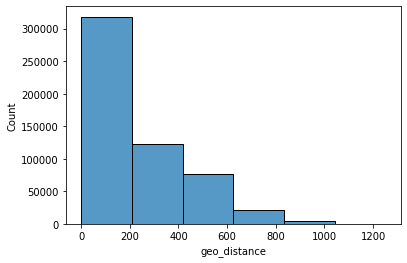

In [ ]:
sns.histplot(data=data_h4, x="geo_distance", bins=6)
plt.show()

In [ ]:
for min_thr, max_thr in [(0, 200), (200, 400), (400, 600), (600, 800), (800, 1000)]:
    hypothesis_mask = (data_h4["geo_distance"] >= min_thr) & (data_h4["geo_distance"] < max_thr)
    hypothesis_df = data_h4[hypothesis_mask]["economy"]
    alternative_df = data_h4[~hypothesis_mask]["economy"]
    
    print(f"Distance>{min_thr} and Distance<{max_thr}")
    
    # t-test for equal mean values
    _, pvalue, _ = sm.stats.ttest_ind(hypothesis_df, alternative_df, alternative="larger")
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} mean economy than all others with p-value={pvalue}")

    _, pvalue = scipy.stats.levene(economy_below_thr, economy_above_thr)
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} economy variance than all others with p-value={pvalue}")

Distance>0 and Distance<200
	has sufficiently lower mean economy than all others with p-value=1.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Distance>200 and Distance<400
	has sufficiently higher mean economy than all others with p-value=0.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Distance>400 and Distance<600
	has sufficiently higher mean economy than all others with p-value=1.5407486899307493e-146
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Distance>600 and Distance<800
	has sufficiently higher mean economy than all others with p-value=3.4231716777977873e-115
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Distance>800 and Distance<1000
	has sufficiently higher mean economy than all others with p-value=8.660968576221963e-65
	has sufficiently higher economy variance than all others with 

## Hypothesis #5

#### Season is significant for economy

In [ ]:
data_h5 = full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')].query('(numberOfBids>0)')
data_h5['date'] = pd.to_datetime(data_h5['date'])
data_h5['season'] = (data_h5.date.dt.month - 1) // 3

2    234408
0    228137
1    218382
3    191907
Name: season, dtype: int64

In [ ]:
data_h5 = (data_h5
    [['id', 'lots_id','value_amount', 'awards_value_amount', 'season', 'numberOfBids']]
    .query('numberOfBids>0')
    .groupby(by=['id', 'lots_id', 'season'])
    .agg(min)
    .reset_index()
    .groupby(by=['id', 'season'])
    .agg({
        'value_amount': sum,
        'awards_value_amount': sum,
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount) / d.value_amount,
    )
)

In [ ]:
data_h5.season.value_counts()

2    220259
0    211246
1    201253
3    182565
Name: season, dtype: int64

In [ ]:
season_dict = {
    0: 'spring',
    1: 'summer',
    2: 'autumn',
    3: 'winter'
}

for value in [0, 1, 2 ,3]:
    hypothesis_mask = data_h5["season"] == value
    hypothesis_df = data_h5[hypothesis_mask]["economy"]
    alternative_df = data_h5[~hypothesis_mask]["economy"]
    
    print(f"{season_dict[value]}")
    
    # t-test for equal mean values
    _, pvalue, _ = sm.stats.ttest_ind(hypothesis_df, alternative_df, alternative="larger")
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} mean economy than all others with p-value={pvalue}")

    _, pvalue = scipy.stats.levene(economy_below_thr, economy_above_thr)
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} economy variance than all others with p-value={pvalue}")

spring
	has sufficiently higher mean economy than all others with p-value=8.107863504202709e-114
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
summer
	has sufficiently higher mean economy than all others with p-value=7.447278352118796e-16
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
autumn
	has sufficiently lower mean economy than all others with p-value=1.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
winter
	has sufficiently lower mean economy than all others with p-value=1.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203


## Hypothesis #6

#### Sector is significant for economy

In [ ]:
classifier = DK021.load('./data/dk021.csv')

In [ ]:
data_h6 = full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')].query('(numberOfBids>0)')
data_h6["sectors"] = data_h6.items_classification_l3.apply(lambda x: classifier.get_level_category(x, level=1).description)
sectors = data_h6["sectors"].value_counts()
sector_names = [sector_name for sector_name, sector_occurence in zip(sectors.index, sectors.values) if sector_occurence > 20000]
sector_names

['Будівельні роботи та поточний ремонт',
 'Продукти харчування, напої, тютюн та супутня продукція',
 'Медичне обладнання, фармацевтична продукція та засоби особистої гігієни',
 'Нафтопродукти, паливо, електроенергія та інші джерела енергії',
 'Офісна та комп’ютерна техніка, устаткування та приладдя, крім меблів та пакетів програмного забезпечення',
 'Конструкції та конструкційні матеріали; допоміжна будівельна продукція (крім електроапаратури)',
 'Меблі (у тому числі офісні меблі), меблево-декоративні вироби, побутова техніка (крім освітлювального обладнання) та засоби для чищення',
 'Послуги з ремонту і технічного обслуговування',
 'Сільськогосподарська, фермерська продукція, продукція рибальства, лісівництва та супутня продукція',
 'Транспортне обладнання та допоміжне приладдя до нього',
 'Архітектурні, будівельні, інженерні та інспекційні послуги',
 'Електротехнічне устаткування, апаратура, обладнання та матеріали; освітлювальне устаткування']

In [ ]:
data_h6 = (data_h6[data_h6["sectors"].isin(sector_names)]
    [['id', 'lots_id','value_amount', 'awards_value_amount', 'sectors', 'numberOfBids']]
    .query('numberOfBids>0')
    .groupby(by=['id', 'lots_id', 'sectors'])
    .agg(min)
    .reset_index()
    .groupby(by=['id', 'sectors'])
    .agg({
        'value_amount': sum,
        'awards_value_amount': sum,
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount) / d.value_amount,
    )
)

In [ ]:
for sector_name in sector_names:
    hypothesis_mask = data_h6["sectors"] == sector_name
    hypothesis_df = data_h6[hypothesis_mask]["economy"]
    alternative_df = data_h6[~hypothesis_mask]["economy"]
    
    print(sector_name)
    
    # t-test for equal mean values
    _, pvalue, _ = sm.stats.ttest_ind(hypothesis_df, alternative_df, alternative="larger")
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} mean economy than all others with p-value={pvalue}")

    _, pvalue = scipy.stats.levene(economy_below_thr, economy_above_thr)
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} economy variance than all others with p-value={pvalue}")

Будівельні роботи та поточний ремонт
	has sufficiently lower mean economy than all others with p-value=1.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Продукти харчування, напої, тютюн та супутня продукція
	has sufficiently lower mean economy than all others with p-value=1.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Медичне обладнання, фармацевтична продукція та засоби особистої гігієни
	has sufficiently lower mean economy than all others with p-value=1.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Нафтопродукти, паливо, електроенергія та інші джерела енергії
	has sufficiently higher mean economy than all others with p-value=0.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Офісна та комп’ютерна техніка, устаткування та приладдя, крім меблів та пакетів програмного забезпечення
	has suffici

## Hypothesis #7

#### Number of already participated tenders is significant for economy

In [ ]:
data_h7 = full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')].query('(numberOfBids>0)')

In [ ]:
data_h7 = data_h7.sort_values("date")

In [ ]:
import tqdm

In [ ]:
unique_visits = dict()
visited_tenders = dict()
visits = []
for email, tender_id in tqdm.tqdm(zip(data_h7.bids_tenderers_contactPoint_email, data_h7.id)):
    key = f"{email}#{tender_id}"
    if key in visited_tenders:
        value = visited_tenders[key]
    else:
        if email in unique_visits:
            value = unique_visits[email]
            unique_visits[email] += 1
        else:
            value = 0
            unique_visits[email] = 1
        visited_tenders[key] = value
    visits.append(value)

872834it [00:03, 237153.83it/s]


In [ ]:
data_h7["visits"] = visits

In [ ]:
data_h7 = (data_h7
    [['id', 'lots_id','value_amount', 'awards_value_amount', 'visits', 'numberOfBids']]
    .query('numberOfBids>0')
    .groupby(by=['id', 'lots_id', 'visits'])
    .agg(min)
    .reset_index()
    .groupby(by=['id', 'visits'])
    .agg({
        'value_amount': sum,
        'awards_value_amount': sum,
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount) / d.value_amount,
    )
)

In [ ]:
for min_thr, max_thr in [(0, 5), (5, 10), (10, 20), (20, 40), (40, 60), (60, 80), (80, 100), (100, 200), (200, 300), (300, 500), (500, 1500)]:
    hypothesis_mask = (data_h7["visits"] >= min_thr) & (data_h7["visits"] < max_thr)
    hypothesis_df = data_h7[hypothesis_mask]["economy"]
    alternative_df = data_h7[~hypothesis_mask]["economy"]
    
    print(f"Visits>{min_thr} and Visits<{max_thr}")
    
    # t-test for equal mean values
    _, pvalue, _ = sm.stats.ttest_ind(hypothesis_df, alternative_df, alternative="larger")
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} mean economy than all others with p-value={pvalue}")

    _, pvalue = scipy.stats.levene(economy_below_thr, economy_above_thr)
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} economy variance than all others with p-value={pvalue}")

Visits>0 and Visits<5
	has sufficiently lower mean economy than all others with p-value=1.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Visits>5 and Visits<10
	has sufficiently lower mean economy than all others with p-value=1.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Visits>10 and Visits<20
	has sufficiently lower mean economy than all others with p-value=0.9957790873784681
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Visits>20 and Visits<40
	has sufficiently higher mean economy than all others with p-value=1.634207119207452e-35
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Visits>40 and Visits<60
	has sufficiently higher mean economy than all others with p-value=4.586115428486657e-74
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Visits>60 

## Example Economy

In [ ]:
full_df[full_df.id=='98d54c150056474fbedb5420f8aad0d9'][['id', 'lots_id',  'bids_id', 'items_code', 'items_classification_l1', 'items_classification_l2', 'items_classification_l3', 'numberOfBids', 'num_lots',  'awards_status', 'status', 'value_amount', 'bids_value_amount', 'awards_value_amount']]

,id,lots_id,bids_id,items_code,items_classification_l1,items_classification_l2,items_classification_l3,numberOfBids,num_lots,awards_status,status,value_amount,bids_value_amount,awards_value_amount
76067,98d54c150056474fbedb5420f8aad0d9,76da00fa661a4e51bf34f0e791833bd2,1215fd8627904632b2771d21998006e5,33141113-4,33000000-0,33100000-1,33140000-3,2,2,NaN,complete,1060036.0,1052085.85,NaN
76068,98d54c150056474fbedb5420f8aad0d9,76da00fa661a4e51bf34f0e791833bd2,15935b3d80944ce2b1fa5bdc63bcc5d3,33141113-4,33000000-0,33100000-1,33140000-3,2,2,active,complete,1060036.0,1019377.02,1019377.02
76069,98d54c150056474fbedb5420f8aad0d9,e32dc54313cf4e22862196b85299d87f,1215fd8627904632b2771d21998006e5,33140000-3,33000000-0,33100000-1,33140000-3,2,2,NaN,complete,2270252.0,2267523.67,NaN
76070,98d54c150056474fbedb5420f8aad0d9,e32dc54313cf4e22862196b85299d87f,15935b3d80944ce2b1fa5bdc63bcc5d3,33140000-3,33000000-0,33100000-1,33140000-3,2,2,active,complete,2270252.0,2266848.50,2266848.50


In [ ]:
classifier = DK021.load('./data/dk021.csv')

In [ ]:
(
    full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')]
    [['id', 'lots_id', 'numberOfBids','value_amount', 'awards_value_amount']]
    .groupby(by=['id', 'lots_id'])
    .agg(min)
    .reset_index()
    .assign(
        economy = lambda d: d.value_amount - d.awards_value_amount,
        est_economy = lambda d: d.value_amount - d.value_amount*0.65
    )
)[['economy', 'est_economy']].astype(np.int64).sum()

economy        132597677057
est_economy    546155392707
dtype: int64

In [ ]:
cnt_eco=(
    full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')]
    [['id', 'lots_id', 'numberOfBids','value_amount', 'awards_value_amount']]
    .query('numberOfBids>0')
    .groupby(by=['id', 'lots_id'])
    .agg(min)
    .reset_index()
    .groupby(by=['id'])
    .agg({
        'numberOfBids': min,
        'value_amount': sum,
        'awards_value_amount': sum
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount) /d.value_amount
    )
    .groupby(by=['numberOfBids'])
    .agg({
        'id': 'count',
        'economy': 'mean',
        'value_amount': sum,
        'awards_value_amount': sum
    })
    .reset_index()
    .rename(columns={'id':'cnt'})
    .query('cnt>1000')
    .sort_values(by='numberOfBids')
    .assign(
        count_log = lambda d: np.log2(d.cnt)*15
    )
)
cnt_eco

,numberOfBids,cnt,economy,value_amount,awards_value_amount,count_log
0,1,272064,4.818293,5.545546e+10,5.364767e+10,270.803798
1,2,300337,10.025346,8.612403e+11,8.116753e+11,272.943340
2,3,120906,18.662282,3.106225e+11,2.792178e+11,253.252895
3,4,59413,23.539578,1.292211e+11,1.112743e+11,237.877365
4,5,28961,28.048722,7.365568e+10,6.141915e+10,222.327357
5,6,14807,30.416978,2.792069e+10,2.291922e+10,207.809876
6,7,7794,33.004112,2.568979e+10,2.031637e+10,193.922223
7,8,4498,33.923021,2.605870e+10,2.308378e+10,182.026019
8,9,2469,35.615195,8.148888e+09,6.866796e+09,169.045667
9,10,1461,36.696603,8.343116e+09,7.052200e+09,157.691107


In [ ]:
avg_eco = 100*(cnt_eco.value_amount.sum() - cnt_eco.awards_value_amount.sum()) / cnt_eco.value_amount.sum()
avg_eco

8.443876365284083

In [ ]:
avg_eco_at_5 = cnt_eco[cnt_eco.numberOfBids == 5].economy.iloc[0]
avg_eco_at_5

28.048721521108288

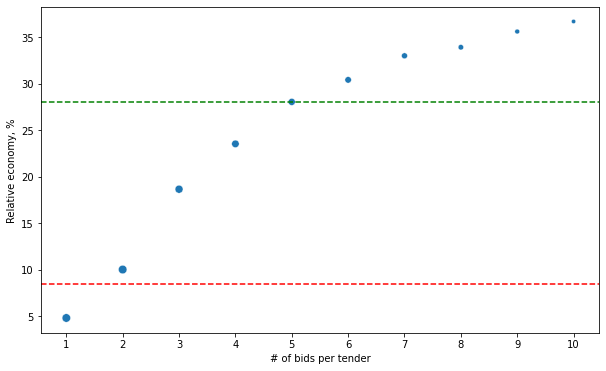

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,6))
ax.axhline(avg_eco, ls='--', color='red')
ax.axhline(avg_eco_at_5, ls='--', color='green')
ax = sns.scatterplot(ax=ax, data=cnt_eco, x="numberOfBids", palette="deep", y="economy", size='count_log', legend=False)
ax.set_xlabel('# of bids per tender')
ax.set_ylabel('Relative economy, %')
ax.set_xticks(cnt_eco.numberOfBids.to_list());

In [17]:
import pandas as pd 
import numpy as np
from functools import partial
from glob import glob

from pymongo import MongoClient

import statsmodels.api as sm
import scipy

from utils.misc import read_mongo, batch
from utils.geolocation import CachedGeolocator, region_fixer, locality_fixer, countryName_fixer, address_to_location
from utils.dk021 import DK021
from utils.etl import transform_dataset

%matplotlib inline

# Prepare data

## Transform Chunked

In [ ]:
batch_size = 50_000

# connect to tenders db
cursor = MongoClient()['prozorro']['etenders'].find(no_cursor_timeout=True)

try:
    for idx, b in enumerate(batch(cursor, batch_size)):

        transform_dataset(
            df=pd.DataFrame(b).rename(columns={'_id':'id'})
        ).to_parquet(f'./data/prepared/chunk_{idx}.parquet.gzip', compression='gzip') 

        print(f'chunk {idx}')
# except Exception as e:
#     print(e)
finally:
    cursor.close()

## Restore & enrich

In [ ]:
files = sorted(glob('./data/prepared/chunk_*.parquet.gzip'))

full_df = pd.read_parquet(files[0])
for f in files[1:]:
    full_df = pd.concat([full_df, pd.read_parquet(f)])


In [ ]:
classifier = DK021.load('./data/dk021.csv')

In [8]:
classifier.get_level_category('33141113-4', level=5).description

'Бинти'

In [ ]:
# geo and classifier
fixers = {
    'locality': locality_fixer,
    'region': region_fixer,
    'countryName': countryName_fixer
}
geolocator = CachedGeolocator(cache_dir='./data/geo_cache', bad_cache_dir='./data/geo_cache_bad', verbose=False)
get_location = partial(address_to_location, geolocator=geolocator, fixers=fixers)
classifier = DK021.load('./data/dk021.csv')

full_df = (
    full_df
    .query('~items_code.isna()')
    .assign(
        items_classification_l1 = lambda d: d.items_code.apply(lambda code: classifier.get_level_category(code=code, level=1).code),
        items_classification_l2 = lambda d: d.items_code.apply(lambda code: classifier.get_level_category(code=code, level=2).code),
        items_classification_l3 = lambda d: d.items_code.apply(lambda code: classifier.get_level_category(code=code, level=3).code)
    )
    .assign(
        procuringEntity_geo = lambda d: d.procuringEntity_address.apply(lambda address:get_location(address)),
        bids_tenderers_geo = lambda d: d.tenderers_address.apply(lambda address:get_location(address)),
    )
)

geolocator.close()

# Read data

In [7]:
from utils.misc import mem_usg

classifier = DK021.load('./data/dk021.csv')
full_df = pd.read_parquet('../full.parquet.gzip')

mem_usg(full_df)/(1024*1024)

5108.999673843384

In [8]:
full_df.head()

,id,date,dateModified,tenderID,owner,procurementMethod,submissionMethod,numberOfBids,status,procurementMethodType,...,awards_value_amount,awards_value_currency,awards_value_valueAddedTaxIncluded,items_code,items_classification_l1,items_classification_l2,items_classification_l3,procuringEntity_geo,bids_tenderers_geo,geo_distance
0,54c44b64ee504474afaf1183c410b36c,2018-12-31 22:03:03.722108+00:00,2018-12-31 22:03:03.722108+00:00,UA-2018-11-15-000962-c,it.ua,open,electronicAuction,2,unsuccessful,aboveThresholdUA,...,279770.40,UAH,False,72610000-9,72000000-5,72600000-6,72610000-9,"[47.4970865, 34.6487214]","[49.9923181, 36.2310146]",300.877064
1,54c44b64ee504474afaf1183c410b36c,2018-12-31 22:03:03.722108+00:00,2018-12-31 22:03:03.722108+00:00,UA-2018-11-15-000962-c,it.ua,open,electronicAuction,2,unsuccessful,aboveThresholdUA,...,280612.08,UAH,False,72610000-9,72000000-5,72600000-6,72610000-9,"[47.4970865, 34.6487214]","[49.5897423, 34.5507948]",232.817393
2,4edb5e732a6743d29382e62995cf9ad7,2018-12-31 22:03:01.553692+00:00,2018-12-31 22:03:01.553692+00:00,UA-2018-11-30-001936-c,prom.ua,open,electronicAuction,3,unsuccessful,aboveThresholdUA,...,735000.00,UAH,True,15510000-6,15000000-8,15500000-3,15510000-6,"[49.7132963, 37.6141992]","[49.7132963, 37.6141992]",0.000000
3,4edb5e732a6743d29382e62995cf9ad7,2018-12-31 22:03:01.553692+00:00,2018-12-31 22:03:01.553692+00:00,UA-2018-11-30-001936-c,prom.ua,open,electronicAuction,3,unsuccessful,aboveThresholdUA,...,734650.00,UAH,True,15510000-6,15000000-8,15500000-3,15510000-6,"[49.7132963, 37.6141992]",None,NaN
4,4edb5e732a6743d29382e62995cf9ad7,2018-12-31 22:03:01.553692+00:00,2018-12-31 22:03:01.553692+00:00,UA-2018-11-30-001936-c,prom.ua,open,electronicAuction,3,unsuccessful,aboveThresholdUA,...,867200.00,UAH,True,15510000-6,15000000-8,15500000-3,15510000-6,"[49.7132963, 37.6141992]","[49.9923181, 36.2310146]",104.197987


## Explore

In [9]:
full_df.geo_distance.isna().value_counts()

False    2154765
True      218044
Name: geo_distance, dtype: int64

In [10]:
full_df.awards_status.value_counts()

active          894256
unsuccessful    318514
cancelled        61464
pending          29395
Name: awards_status, dtype: int64

In [11]:
full_df[full_df.id=='98d54c150056474fbedb5420f8aad0d9'][["id", "lots_id", "bids_value_amount", "value_amount", "awards_value_amount", "procurementMethodType", "awards_status"]]

,id,lots_id,bids_value_amount,value_amount,awards_value_amount,procurementMethodType,awards_status
76067,98d54c150056474fbedb5420f8aad0d9,76da00fa661a4e51bf34f0e791833bd2,1052085.85,1060036.0,NaN,aboveThresholdUA,NaN
76068,98d54c150056474fbedb5420f8aad0d9,76da00fa661a4e51bf34f0e791833bd2,1019377.02,1060036.0,1019377.02,aboveThresholdUA,active
76069,98d54c150056474fbedb5420f8aad0d9,e32dc54313cf4e22862196b85299d87f,2267523.67,2270252.0,NaN,aboveThresholdUA,NaN
76070,98d54c150056474fbedb5420f8aad0d9,e32dc54313cf4e22862196b85299d87f,2266848.50,2270252.0,2266848.50,aboveThresholdUA,active


In [12]:
full_df.columns

Index(['id', 'date', 'dateModified', 'tenderID', 'owner', 'procurementMethod',
       'submissionMethod', 'numberOfBids', 'status', 'procurementMethodType',
       'mainProcurementCategory', 'procuringEntity_name',
       'procuringEntity_kind', 'procuringEntity_address', 'num_lots',
       'procuringEntity_identifier_id', 'procuringEntity_identifier_scheme',
       'procuringEntity_contactPoint_email',
       'procuringEntity_contactPoint_name',
       'procuringEntity_contactPoint_telephone', 'lots_id', 'value_amount',
       'value_currency', 'value_valueAddedTaxIncluded', 'lots_status',
       'bids_date', 'bids_id', 'bids_status', 'bids_tenderers_name',
       'bids_tenderers_identifier_id', 'bids_tenderers_identifier_scheme',
       'bids_tenderers_contactPoint_email', 'bids_tenderers_contactPoint_name',
       'bids_tenderers_contactPoint_telephone', 'tenderers_address',
       'bids_value_amount', 'bids_value_currency',
       'bids_value_valueAddedTaxIncluded', 'awards_date', 

In [13]:
full_df[full_df.id=='98d54c150056474fbedb5420f8aad0d9']

,id,date,dateModified,tenderID,owner,procurementMethod,submissionMethod,numberOfBids,status,procurementMethodType,...,awards_value_amount,awards_value_currency,awards_value_valueAddedTaxIncluded,items_code,items_classification_l1,items_classification_l2,items_classification_l3,procuringEntity_geo,bids_tenderers_geo,geo_distance
76067,98d54c150056474fbedb5420f8aad0d9,2021-09-01 07:01:34.905329+00:00,2021-09-01 07:01:34.905329+00:00,UA-2021-07-28-004065-b,e-tender.biz,open,electronicAuction,2,complete,aboveThresholdUA,...,NaN,NaN,True,33141113-4,33000000-0,33100000-1,33140000-3,"[50.587515499999995, 30.48936284691901]","[48.5167748, 34.6068797]",376.483135
76068,98d54c150056474fbedb5420f8aad0d9,2021-09-01 07:01:34.905329+00:00,2021-09-01 07:01:34.905329+00:00,UA-2021-07-28-004065-b,e-tender.biz,open,electronicAuction,2,complete,aboveThresholdUA,...,1019377.02,UAH,True,33141113-4,33000000-0,33100000-1,33140000-3,"[50.587515499999995, 30.48936284691901]","[50.587515499999995, 30.48936284691901]",0.000000
76069,98d54c150056474fbedb5420f8aad0d9,2021-09-01 07:01:34.905329+00:00,2021-09-01 07:01:34.905329+00:00,UA-2021-07-28-004065-b,e-tender.biz,open,electronicAuction,2,complete,aboveThresholdUA,...,NaN,NaN,True,33140000-3,33000000-0,33100000-1,33140000-3,"[50.587515499999995, 30.48936284691901]","[48.5167748, 34.6068797]",376.483135
76070,98d54c150056474fbedb5420f8aad0d9,2021-09-01 07:01:34.905329+00:00,2021-09-01 07:01:34.905329+00:00,UA-2021-07-28-004065-b,e-tender.biz,open,electronicAuction,2,complete,aboveThresholdUA,...,2266848.50,UAH,True,33140000-3,33000000-0,33100000-1,33140000-3,"[50.587515499999995, 30.48936284691901]","[50.587515499999995, 30.48936284691901]",0.000000


# Hypotheses

## Hypothesis #1

#### Number of bids is significant for economy

In [14]:
data_h1 = (
    full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')]
    [['id', 'lots_id', 'numberOfBids','value_amount', 'awards_value_amount']]
    .query('numberOfBids>0')
    .groupby(by=['id', 'lots_id'])
    .agg(min)
    .reset_index()
    .groupby(by=['id'])
    .agg({
        'numberOfBids': min,
        'value_amount': sum,
        'awards_value_amount': sum,
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount) / d.value_amount,
    )
)

In [15]:
num_of_bids_count = (
    data_h1[["id", "numberOfBids"]]
    .groupby(by=["numberOfBids"])
    .agg({
        "id": "count",
    })
    .reset_index()
    .rename(columns={"id": "count"})
    .query("count>1000")
)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='numberOfBids', ylabel='economy'>

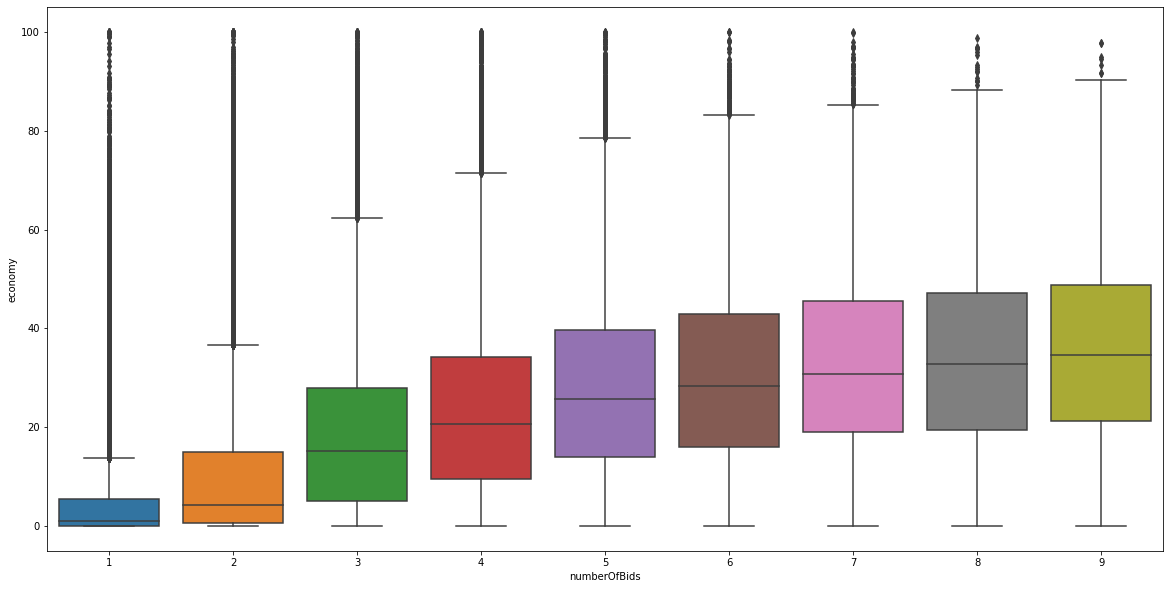

In [23]:
data_h1_boxplot = data_h1[data_h1["numberOfBids"] < num_of_bids_count["numberOfBids"].max()]

plt.figure(figsize=(20, 10))
sns.boxplot(data=data_h1_boxplot, x="numberOfBids", y="economy")

In [24]:
for thr in num_of_bids_count["numberOfBids"]:
    above_thr_mask = data_h1["numberOfBids"] > thr
    economy_below_thr = data_h1[~above_thr_mask]["economy"]
    economy_above_thr = data_h1[above_thr_mask]["economy"]
    
    print(f"NumberOfBids>{thr}")
    
    # t-test for equal mean values
    _, pvalue, _ = sm.stats.ttest_ind(economy_above_thr, economy_below_thr, alternative="larger")
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} mean economy than NumberOfBids<={thr}")#" with p-value={pvalue}")
    
    # print(economy_above_thr.var(), economy_below_thr.var())
    # f = economy_above_thr.var() / economy_below_thr.var()
    # pvalue = 1 - scipy.stats.f.cdf(f, len(economy_above_thr) - 1, len(economy_below_thr) - 1)
    
    # levene’s for equal variances
    _, pvalue = scipy.stats.levene(economy_below_thr, economy_above_thr)
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} economy variance than NumberOfBids<={thr}")#" with p-value={pvalue}")

NumberOfBids>1
	has sufficiently higher mean economy than NumberOfBids<=1
	has sufficiently higher economy variance than NumberOfBids<=1
NumberOfBids>2
	has sufficiently higher mean economy than NumberOfBids<=2
	has sufficiently higher economy variance than NumberOfBids<=2
NumberOfBids>3
	has sufficiently higher mean economy than NumberOfBids<=3
	has sufficiently higher economy variance than NumberOfBids<=3
NumberOfBids>4
	has sufficiently higher mean economy than NumberOfBids<=4
	has sufficiently higher economy variance than NumberOfBids<=4
NumberOfBids>5
	has sufficiently higher mean economy than NumberOfBids<=5
	has sufficiently higher economy variance than NumberOfBids<=5
NumberOfBids>6
	has sufficiently higher mean economy than NumberOfBids<=6
	has sufficiently higher economy variance than NumberOfBids<=6
NumberOfBids>7
	has sufficiently higher mean economy than NumberOfBids<=7
	has sufficiently higher economy variance than NumberOfBids<=7
NumberOfBids>8
	has sufficiently higher m

## Hypothesis #2

#### Region is significant for economy

In [25]:
region_map_dict = {
    "Киевская": "Київська область",
    "Киевская область": "Київська область",
    "КИЕВСКАЯ ОБЛ.": "Київська область",
    "Київ": "Київська область",
    "Киев": "Київська область",
    "місто Київ": "Київська область",
    "м. Київ": "Київська область",
    "м.Київ": "Київська область",
    "Полтавская область": "Полтавська область",
    "Днепропетровская область": "Дніпропетровська область",
    "Днепропетровская обл.": "Дніпропетровська область",
    "Запорожская область": "Запорізька область",
    "Харьковская область": "Харківська область",
    "Днiпропетровська область": "Дніпропетровська область",
    "дніпропетровська": "Дніпропетровська область",
    "Одесская область": "Одеська область",
}

def format_regions(region: str):
    if not region or region in {"1", "Україна"}:
        return None
    region = region.strip()
    region = region.replace("обл.", "область")
    region = region_map_dict.get(region, region)
    words = region.split(" ")
    if len(words) == 1:
        words.append("область")
    return " ".join(words)

data_h2_orig = (
    full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')]
    [['id', 'lots_id', 'numberOfBids','value_amount', 'awards_value_amount', 'tenderers_address']]
    .query('numberOfBids>0')
    .reset_index()
)

data_h2 = (
    data_h2_orig
    .groupby(by=['id', 'lots_id'])
    .agg(min)
    .reset_index()
    .groupby(by=['id'])
    .agg({
        'numberOfBids': min,
        'value_amount': sum,
        'awards_value_amount': sum,
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount) / d.value_amount,
    )
)

regions = (
    data_h2_orig["tenderers_address"]
    .map(lambda x: x["region"])
    .map(format_regions)
)

region_counts = (
    regions
    .to_frame()
    .groupby("tenderers_address")
    .tenderers_address
    .transform("size")
)

data_h2["bids_region"] = regions
data_h2 = data_h2[regions.astype(bool) & (region_counts > 100)]

/home/roman/miniconda3/envs/study/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<AxesSubplot:xlabel='economy', ylabel='bids_region'>

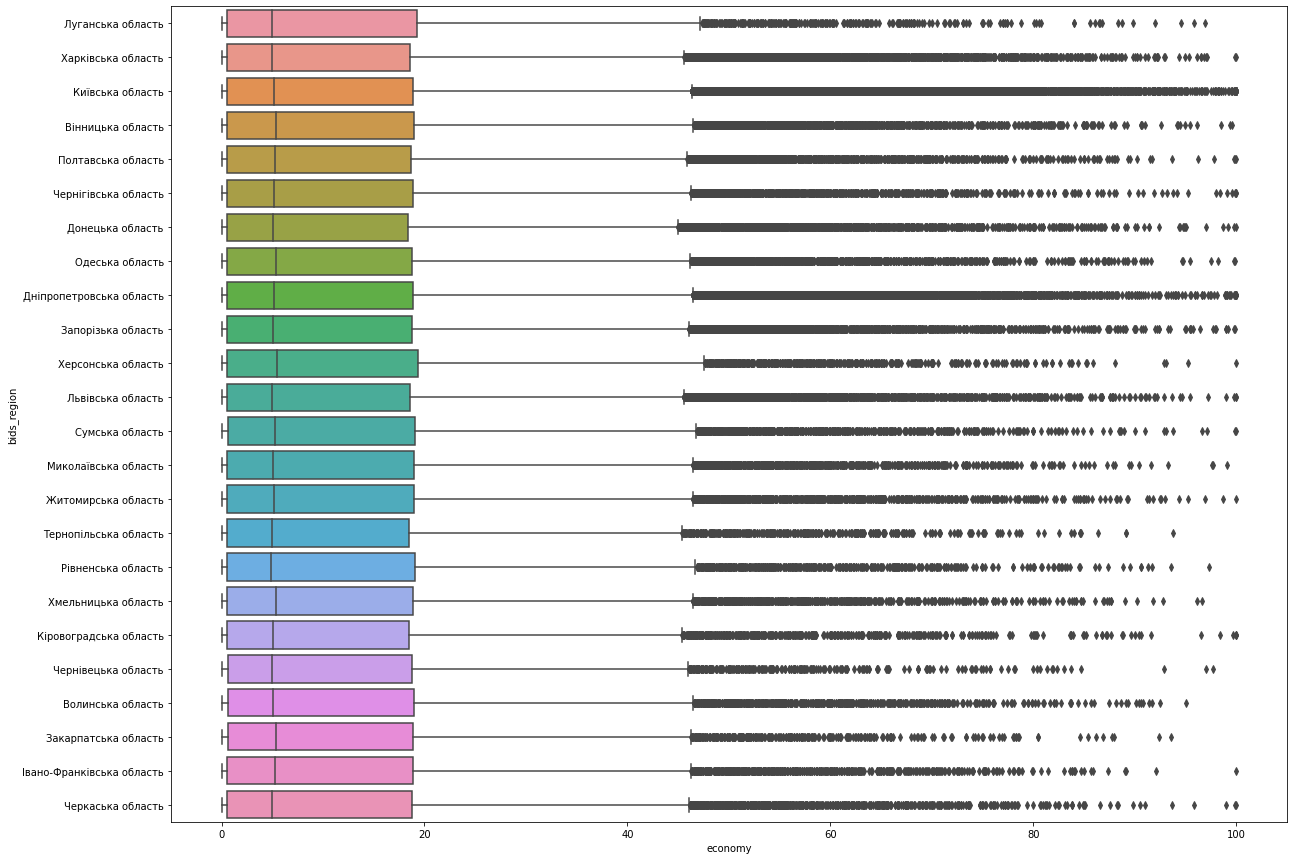

In [26]:
plt.figure(figsize=(20, 15))
sns.boxplot(data=data_h2, x="economy", y="bids_region")

## Hypothesis #3

In [324]:
date_grouper = pd.Grouper(key="date", freq="1M")
data_h3 = (
    full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')]
    [['id', 'lots_id', 'numberOfBids', 'date']]
    .query('numberOfBids>0')
    .groupby([, "numberOfBids"])
    .agg({
        'id': "count",
    })
    .rename(columns={"id": "count"})
    .reset_index()
)

<AxesSubplot:xlabel='date', ylabel='count'>

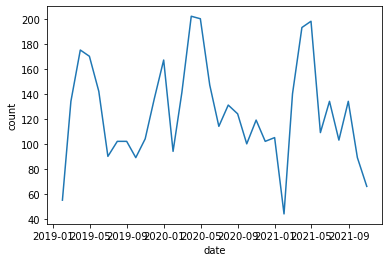

In [334]:
sns.lineplot(data=data_h3[data_h3["numberOfBids"] == 9], x="date", y="count")

## Hypothesis #4

#### Distance is significant for economy

In [201]:
data_h4 = full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')].query('(numberOfBids>0) & (~geo_distance.isna()) & (geo_distance > 0)')
data_h4 = (data_h4
    [['id', 'lots_id','value_amount', 'awards_value_amount', 'geo_distance', 'numberOfBids']]
    .query('numberOfBids>0')
    .groupby(by=['id', 'lots_id'])
    .agg(min)
    .reset_index()
    .groupby(by=['id'])
    .agg({
        'value_amount': sum,
        'awards_value_amount': sum,
        'geo_distance': 'mean',
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount) / d.value_amount,
    )
)

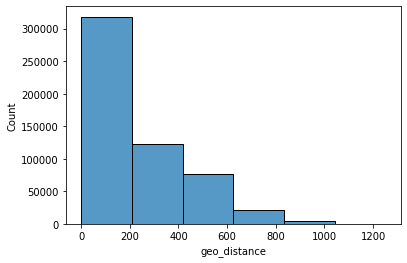

In [202]:
sns.histplot(data=data_h4, x="geo_distance", bins=6)
plt.show()

In [203]:
for min_thr, max_thr in [(0, 200), (200, 400), (400, 600), (600, 800), (800, 1000)]:
    hypothesis_mask = (data_h4["geo_distance"] >= min_thr) & (data_h4["geo_distance"] < max_thr)
    hypothesis_df = data_h4[hypothesis_mask]["economy"]
    alternative_df = data_h4[~hypothesis_mask]["economy"]
    
    print(f"Distance>{min_thr} and Distance<{max_thr}")
    
    # t-test for equal mean values
    _, pvalue, _ = sm.stats.ttest_ind(hypothesis_df, alternative_df, alternative="larger")
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} mean economy than all others with p-value={pvalue}")

    _, pvalue = scipy.stats.levene(economy_below_thr, economy_above_thr)
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} economy variance than all others with p-value={pvalue}")

Distance>0 and Distance<200
	has sufficiently lower mean economy than all others with p-value=1.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Distance>200 and Distance<400
	has sufficiently higher mean economy than all others with p-value=0.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Distance>400 and Distance<600
	has sufficiently higher mean economy than all others with p-value=1.5407486899307493e-146
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Distance>600 and Distance<800
	has sufficiently higher mean economy than all others with p-value=3.4231716777977873e-115
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Distance>800 and Distance<1000
	has sufficiently higher mean economy than all others with p-value=8.660968576221963e-65
	has sufficiently higher economy variance than all others with 

## Hypothesis #5

#### Season is significant for economy

In [141]:
data_h5 = full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')].query('(numberOfBids>0)')
data_h5['date'] = pd.to_datetime(data_h5['date'])
data_h5['season'] = (data_h5.date.dt.month - 1) // 3

2    234408
0    228137
1    218382
3    191907
Name: season, dtype: int64

In [142]:
data_h5 = (data_h5
    [['id', 'lots_id','value_amount', 'awards_value_amount', 'season', 'numberOfBids']]
    .query('numberOfBids>0')
    .groupby(by=['id', 'lots_id', 'season'])
    .agg(min)
    .reset_index()
    .groupby(by=['id', 'season'])
    .agg({
        'value_amount': sum,
        'awards_value_amount': sum,
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount) / d.value_amount,
    )
)

In [145]:
data_h5.season.value_counts()

2    220259
0    211246
1    201253
3    182565
Name: season, dtype: int64

In [143]:
season_dict = {
    0: 'spring',
    1: 'summer',
    2: 'autumn',
    3: 'winter'
}

for value in [0, 1, 2 ,3]:
    hypothesis_mask = data_h5["season"] == value
    hypothesis_df = data_h5[hypothesis_mask]["economy"]
    alternative_df = data_h5[~hypothesis_mask]["economy"]
    
    print(f"{season_dict[value]}")
    
    # t-test for equal mean values
    _, pvalue, _ = sm.stats.ttest_ind(hypothesis_df, alternative_df, alternative="larger")
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} mean economy than all others with p-value={pvalue}")

    _, pvalue = scipy.stats.levene(economy_below_thr, economy_above_thr)
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} economy variance than all others with p-value={pvalue}")

spring
	has sufficiently higher mean economy than all others with p-value=8.107863504202709e-114
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
summer
	has sufficiently higher mean economy than all others with p-value=7.447278352118796e-16
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
autumn
	has sufficiently lower mean economy than all others with p-value=1.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
winter
	has sufficiently lower mean economy than all others with p-value=1.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203


## Hypothesis #6

#### Sector is significant for economy

In [147]:
classifier = DK021.load('./data/dk021.csv')

In [150]:
data_h6 = full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')].query('(numberOfBids>0)')
data_h6["sectors"] = data_h6.items_classification_l3.apply(lambda x: classifier.get_level_category(x, level=1).description)
sectors = data_h6["sectors"].value_counts()
sector_names = [sector_name for sector_name, sector_occurence in zip(sectors.index, sectors.values) if sector_occurence > 20000]
sector_names

['Будівельні роботи та поточний ремонт',
 'Продукти харчування, напої, тютюн та супутня продукція',
 'Медичне обладнання, фармацевтична продукція та засоби особистої гігієни',
 'Нафтопродукти, паливо, електроенергія та інші джерела енергії',
 'Офісна та комп’ютерна техніка, устаткування та приладдя, крім меблів та пакетів програмного забезпечення',
 'Конструкції та конструкційні матеріали; допоміжна будівельна продукція (крім електроапаратури)',
 'Меблі (у тому числі офісні меблі), меблево-декоративні вироби, побутова техніка (крім освітлювального обладнання) та засоби для чищення',
 'Послуги з ремонту і технічного обслуговування',
 'Сільськогосподарська, фермерська продукція, продукція рибальства, лісівництва та супутня продукція',
 'Транспортне обладнання та допоміжне приладдя до нього',
 'Архітектурні, будівельні, інженерні та інспекційні послуги',
 'Електротехнічне устаткування, апаратура, обладнання та матеріали; освітлювальне устаткування']

In [151]:
data_h6 = (data_h6[data_h6["sectors"].isin(sector_names)]
    [['id', 'lots_id','value_amount', 'awards_value_amount', 'sectors', 'numberOfBids']]
    .query('numberOfBids>0')
    .groupby(by=['id', 'lots_id', 'sectors'])
    .agg(min)
    .reset_index()
    .groupby(by=['id', 'sectors'])
    .agg({
        'value_amount': sum,
        'awards_value_amount': sum,
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount) / d.value_amount,
    )
)

In [154]:
for sector_name in sector_names:
    hypothesis_mask = data_h6["sectors"] == sector_name
    hypothesis_df = data_h6[hypothesis_mask]["economy"]
    alternative_df = data_h6[~hypothesis_mask]["economy"]
    
    print(sector_name)
    
    # t-test for equal mean values
    _, pvalue, _ = sm.stats.ttest_ind(hypothesis_df, alternative_df, alternative="larger")
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} mean economy than all others with p-value={pvalue}")

    _, pvalue = scipy.stats.levene(economy_below_thr, economy_above_thr)
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} economy variance than all others with p-value={pvalue}")

Будівельні роботи та поточний ремонт
	has sufficiently lower mean economy than all others with p-value=1.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Продукти харчування, напої, тютюн та супутня продукція
	has sufficiently lower mean economy than all others with p-value=1.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Медичне обладнання, фармацевтична продукція та засоби особистої гігієни
	has sufficiently lower mean economy than all others with p-value=1.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Нафтопродукти, паливо, електроенергія та інші джерела енергії
	has sufficiently higher mean economy than all others with p-value=0.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Офісна та комп’ютерна техніка, устаткування та приладдя, крім меблів та пакетів програмного забезпечення
	has suffici

## Hypothesis #7

#### Number of already participated tenders is significant for economy

In [189]:
data_h7 = full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')].query('(numberOfBids>0)')

In [190]:
data_h7 = data_h7.sort_values("date")

In [191]:
import tqdm

In [192]:
unique_visits = dict()
visited_tenders = dict()
visits = []
for email, tender_id in tqdm.tqdm(zip(data_h7.bids_tenderers_contactPoint_email, data_h7.id)):
    key = f"{email}#{tender_id}"
    if key in visited_tenders:
        value = visited_tenders[key]
    else:
        if email in unique_visits:
            value = unique_visits[email]
            unique_visits[email] += 1
        else:
            value = 0
            unique_visits[email] = 1
        visited_tenders[key] = value
    visits.append(value)

872834it [00:03, 237153.83it/s]


In [193]:
data_h7["visits"] = visits

In [194]:
data_h7 = (data_h7
    [['id', 'lots_id','value_amount', 'awards_value_amount', 'visits', 'numberOfBids']]
    .query('numberOfBids>0')
    .groupby(by=['id', 'lots_id', 'visits'])
    .agg(min)
    .reset_index()
    .groupby(by=['id', 'visits'])
    .agg({
        'value_amount': sum,
        'awards_value_amount': sum,
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount) / d.value_amount,
    )
)

In [205]:
for min_thr, max_thr in [(0, 5), (5, 10), (10, 20), (20, 40), (40, 60), (60, 80), (80, 100), (100, 200), (200, 300), (300, 500), (500, 1500)]:
    hypothesis_mask = (data_h7["visits"] >= min_thr) & (data_h7["visits"] < max_thr)
    hypothesis_df = data_h7[hypothesis_mask]["economy"]
    alternative_df = data_h7[~hypothesis_mask]["economy"]
    
    print(f"Visits>{min_thr} and Visits<{max_thr}")
    
    # t-test for equal mean values
    _, pvalue, _ = sm.stats.ttest_ind(hypothesis_df, alternative_df, alternative="larger")
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} mean economy than all others with p-value={pvalue}")

    _, pvalue = scipy.stats.levene(economy_below_thr, economy_above_thr)
    print(f"\thas sufficiently {'higher' if pvalue < 0.05 else 'lower'} economy variance than all others with p-value={pvalue}")

Visits>0 and Visits<5
	has sufficiently lower mean economy than all others with p-value=1.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Visits>5 and Visits<10
	has sufficiently lower mean economy than all others with p-value=1.0
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Visits>10 and Visits<20
	has sufficiently lower mean economy than all others with p-value=0.9957790873784681
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Visits>20 and Visits<40
	has sufficiently higher mean economy than all others with p-value=1.634207119207452e-35
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Visits>40 and Visits<60
	has sufficiently higher mean economy than all others with p-value=4.586115428486657e-74
	has sufficiently higher economy variance than all others with p-value=3.390989018559413e-203
Visits>60 

## Example Economy

In [6]:
full_df[full_df.id=='98d54c150056474fbedb5420f8aad0d9'][['id', 'lots_id',  'bids_id', 'items_code', 'items_classification_l1', 'items_classification_l2', 'items_classification_l3', 'numberOfBids', 'num_lots',  'awards_status', 'status', 'value_amount', 'bids_value_amount', 'awards_value_amount']]

,id,lots_id,bids_id,items_code,items_classification_l1,items_classification_l2,items_classification_l3,numberOfBids,num_lots,awards_status,status,value_amount,bids_value_amount,awards_value_amount
76067,98d54c150056474fbedb5420f8aad0d9,76da00fa661a4e51bf34f0e791833bd2,1215fd8627904632b2771d21998006e5,33141113-4,33000000-0,33100000-1,33140000-3,2,2,NaN,complete,1060036.0,1052085.85,NaN
76068,98d54c150056474fbedb5420f8aad0d9,76da00fa661a4e51bf34f0e791833bd2,15935b3d80944ce2b1fa5bdc63bcc5d3,33141113-4,33000000-0,33100000-1,33140000-3,2,2,active,complete,1060036.0,1019377.02,1019377.02
76069,98d54c150056474fbedb5420f8aad0d9,e32dc54313cf4e22862196b85299d87f,1215fd8627904632b2771d21998006e5,33140000-3,33000000-0,33100000-1,33140000-3,2,2,NaN,complete,2270252.0,2267523.67,NaN
76070,98d54c150056474fbedb5420f8aad0d9,e32dc54313cf4e22862196b85299d87f,15935b3d80944ce2b1fa5bdc63bcc5d3,33140000-3,33000000-0,33100000-1,33140000-3,2,2,active,complete,2270252.0,2266848.50,2266848.50


In [7]:
classifier = DK021.load('./data/dk021.csv')

In [9]:
(
    full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')]
    [['id', 'lots_id', 'numberOfBids','value_amount', 'awards_value_amount']]
    .groupby(by=['id', 'lots_id'])
    .agg(min)
    .reset_index()
    .assign(
        economy = lambda d: d.value_amount - d.awards_value_amount,
        est_economy = lambda d: d.value_amount - d.value_amount*0.65
    )
)[['economy', 'est_economy']].astype(np.int64).sum()

economy        132597677057
est_economy    546155392707
dtype: int64

In [10]:
cnt_eco=(
    full_df[(full_df.status=='complete') & (full_df.awards_status == 'active')]
    [['id', 'lots_id', 'numberOfBids','value_amount', 'awards_value_amount']]
    .query('numberOfBids>0')
    .groupby(by=['id', 'lots_id'])
    .agg(min)
    .reset_index()
    .groupby(by=['id'])
    .agg({
        'numberOfBids': min,
        'value_amount': sum,
        'awards_value_amount': sum
    })
    .reset_index()
    .assign(
        economy = lambda d: 100*(d.value_amount - d.awards_value_amount) /d.value_amount
    )
    .groupby(by=['numberOfBids'])
    .agg({
        'id': 'count',
        'economy': 'mean',
        'value_amount': sum,
        'awards_value_amount': sum
    })
    .reset_index()
    .rename(columns={'id':'cnt'})
    .query('cnt>1000')
    .sort_values(by='numberOfBids')
    .assign(
        count_log = lambda d: np.log2(d.cnt)*15
    )
)
cnt_eco

,numberOfBids,cnt,economy,value_amount,awards_value_amount,count_log
0,1,272064,4.818293,5.545546e+10,5.364767e+10,270.803798
1,2,300337,10.025346,8.612403e+11,8.116753e+11,272.943340
2,3,120906,18.662282,3.106225e+11,2.792178e+11,253.252895
3,4,59413,23.539578,1.292211e+11,1.112743e+11,237.877365
4,5,28961,28.048722,7.365568e+10,6.141915e+10,222.327357
5,6,14807,30.416978,2.792069e+10,2.291922e+10,207.809876
6,7,7794,33.004112,2.568979e+10,2.031637e+10,193.922223
7,8,4498,33.923021,2.605870e+10,2.308378e+10,182.026019
8,9,2469,35.615195,8.148888e+09,6.866796e+09,169.045667
9,10,1461,36.696603,8.343116e+09,7.052200e+09,157.691107


In [11]:
avg_eco = 100*(cnt_eco.value_amount.sum() - cnt_eco.awards_value_amount.sum()) / cnt_eco.value_amount.sum()
avg_eco

8.443876365284083

In [14]:
avg_eco_at_5 = cnt_eco[cnt_eco.numberOfBids == 5].economy.iloc[0]
avg_eco_at_5

28.048721521108288

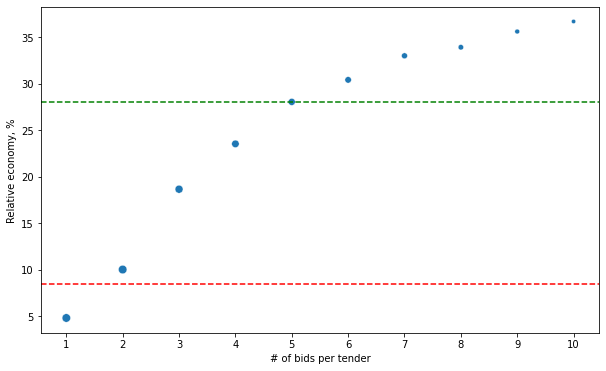

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,6))
ax.axhline(avg_eco, ls='--', color='red')
ax.axhline(avg_eco_at_5, ls='--', color='green')
ax = sns.scatterplot(ax=ax, data=cnt_eco, x="numberOfBids", palette="deep", y="economy", size='count_log', legend=False)
ax.set_xlabel('# of bids per tender')
ax.set_ylabel('Relative economy, %')
ax.set_xticks(cnt_eco.numberOfBids.to_list());